<a href="https://colab.research.google.com/github/ailab-nda/ML/blob/main/Yahoo_Realtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell

# 更新を実行
sudo apt -y update

# ダウンロードのために必要なパッケージをインストール
sudo apt install -y wget curl unzip libvulkan1
# 以下はChromeの依存パッケージ
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb

# Chromeのインストール
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

# Chrome Driverのインストール
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
#wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/117.0.5938.92/linux64/chromedriver-linux64.zip
unzip chromedriver-linux64.zip
chmod +x /content/chromedriver-linux64/chromedriver
mv /content/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [498 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,014 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [998 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,283 kB]
Hit:13 https://pp

In [ ]:
!google-chrome --version
!chromedriver --version

Google Chrome 117.0.5938.92 
ChromeDriver 117.0.5938.92 (67649b10b92bb182fba357831ef7dd6a1baa5648-refs/branch-heads/5938_62@{#14})


In [ ]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
#ライブラリ等のインポート
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import re
import pandas as pd
from datetime import datetime, timedelta
import urllib.parse

from bs4 import BeautifulSoup
import time

In [ ]:
# クエリを設定
query = "防衛大学校"
query = urllib.parse.quote(query)
url = f"https://search.yahoo.co.jp/realtime/search?p={query}&gm=w"
url

'https://search.yahoo.co.jp/realtime/search?p=%E9%98%B2%E8%A1%9B%E5%A4%A7%E5%AD%A6%E6%A0%A1&gm=w'

In [ ]:
# ブラウザをheadlessモード実行
options = webdriver.ChromeOptions()
#ヘッドレスモード（バックグラウンドで起動）で実行。コラボの場合、必須。
options.add_argument('--headless')
#サンドボックスモードの解除。これも必須。
options.add_argument('--no-sandbox')
#これも設定した方がよい。
options.add_argument('--disable-dev-shm-usage')

In [ ]:
#インスタンス化
driver = webdriver.Chrome(options=options)
#指定したドライバーが見つかるまで待機
driver.implicitly_wait(10)
# ページの取得
driver.get(url)

# 要素が表示されるまで待機
WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH, "//*[@id='graph']/div/div[3]/div[2]/p/span[1]")))
WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.CSS_SELECTOR, ".recharts-curve.recharts-area-curve")))

<selenium.webdriver.remote.webelement.WebElement (session="83bbd4d8d10ffa231da95a6dafc76cce", element="7F7DF5B3E788AE4D5F24D20A763534DD_element_53")>

In [ ]:
# ツイート数の取得
tweet_count = driver.find_element(by=By.XPATH, value="//*[@id='graph']/div/div[3]/div[2]/p/span[1]").text
tweet_count = int(tweet_count.replace(",", ""))

#ツイート推移の取得
time_text = driver.find_element(by=By.CSS_SELECTOR, value=".recharts-curve.recharts-area-curve")
d_element = time_text.get_attribute("d")
modified_string = re.sub(r"[a-zA-Z]", ",", d_element)[1:]
values = modified_string.split(",")[1::6][1:-1]
values = [160 - float(x) for x in values]
max_value = max(values)

#ツイート推移のデータを計算
values = [round((x / max_value) * tweet_count) for x in values]

In [ ]:
#時間インデックスの取得
now = datetime.now()
start_time = now - timedelta(days = 7, hours=-2, minutes=now.minute, seconds=now.second, microseconds=now.microsecond)
hourly_list = [start_time + timedelta(hours=i) for i in range(24*7-1)]

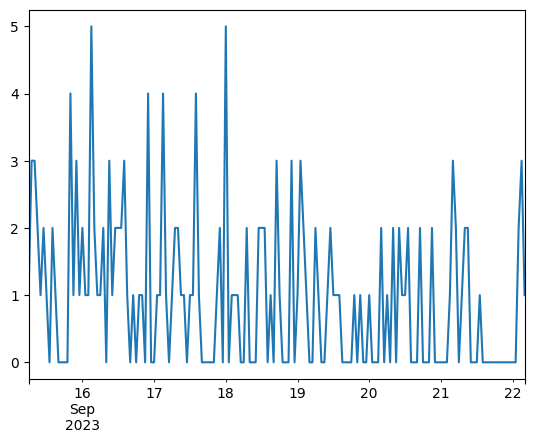

In [ ]:
#結果の表示
s = pd.Series(values, index=hourly_list)
s.plot()

#WebDriverを終了
driver.quit()

In [ ]:
tweets = driver.find_elements(By.CLASS_NAME, "Tweet_body__XtDoj")
print(len(tweets))

40


In [ ]:
for i in tweets:
    print(i.text)

クラウス、士官学校をがっつり良好な成績で卒業した上で知略を武器にすることを選んでる印象があるし、現代で置き換えるならそれこそ防衛大学校とかあのあたりのエリート養成コースのガチ訓練をこなしてきた上で参謀コースという超絶恐ろしいエリートコースなんだよなあ……
返信先:@onoda_kimi
お疲れ様でした。 ありがとうございました。 昨年、防衛大学校で見た小野田さんはとてもかっこよかったです。 これからも応援させていただきます。
愛国コンテンツは根性でなく、なろう感が重要。爆死の『テッパチ！』にならって防衛大学校を舞台にするなら、 主人公はタダで学ぶため入った苦学生でふだんはボンクラだが、実は戦略／戦術の天才。開校以来の超秀才や愛国陶酔秀才を戦略演習で一蹴し、右翼教官の査問を反権力弁舌でやりこめる、とか。
◆陸上自衛隊 89式小銃 二脚 バイポッド 官給品 中古 防衛庁 防衛省 防衛大学校 海上自衛隊 航空自衛隊 64式◆ page.auctions.yahoo.co.jp/jp/auction/f11…
鶴見大学グラウンド 〈第1試合〉10時00分～ ※鶴見大学ー防衛大学校
#ワイドスクランブル　#ANNニュース 1 ゼレンスキー大統領。ウクライナが善でロシアは悪、この図式は欧米諸国では常識になりつつある。だが事実を追う学者、たとえば外務省局長や防衛大学校教授を歴任した孫崎享氏は、複雑な政治と外交の具体的趨勢を追い続けている。 pic.twitter.com/2gMTHNnHXD
＼CFIECウェビナー🖥️無料／ 🔽詳細・申込 peatix.com/event/3700835 『インドが見つめる転換期の世界 日本の対インド戦略に見落としはないのか？』 ＜登壇者＞ 伊藤 融 防衛大学校教授 @itoToru1969 佐藤 隆広 神戸大学教授 椎野 幸平 拓殖大学准教授 奈良部 健 朝日新聞記者 @narabe_takeshi
返信先:@kaburaya20131他1人
吉田茂の防衛大学校第一期学生への言葉が今更ながら胸に沁みますね。「君達が日陰者である時のほうが、国民や日本は幸せなのだ。どうか、耐えてもらいたい」
返信先:@TetraChannel
あおざくら防衛大学校物語 九条の大罪 葬送のフリーレン ウメハラ ファイティングゲーマー 一旦4つ
返信先:@Bd0242